# Demo II & III for the Mathematics with Industry course.

Full demo includes the following examples:
    
    1) A beam propagation method via an external library "diffractio"
    2) Simple Gaussian beam model without attenuation and lens effects
    3) An inversion example based on a simple Gaussian model


## II. Simple Gaussian beam model

This example does not include: attenuation of light by the medium, any effects introduced by the lens system. 

## Compute the beam width:
Beam width:
$w_z = w_0 * \sqrt{1+z^2/z_r^2}$

Rayleigh length:
$z_r = (\pi w_0^2 n) / \lambda$

$FWHM(z) = w_z * \sqrt{2ln2}$

Divergence:
$z_r = {n w_0} / NA$

$NA = n sin \theta$

In [1]:
import numpy
import pylab

w0 = 0.22736420441699337
NA = 0.7
theta = 30.000884802703737
Zr = 0.45472840883398674


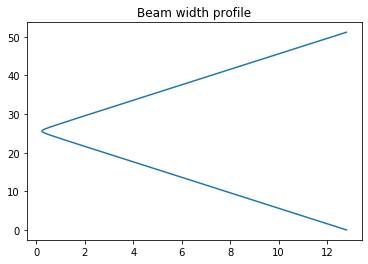

In [2]:
# Define the width of the Gaussian beam:

# Some parametres:
# Nz - grid dimension
# pix - pixel size in microns
# n - refraction index
# wavelength - in microns
# NA - numerical apperture

def gaussian_beam_width(Nz = 256, pix = 0.2, n = 1.4, wavelength = 0.5, NA = 0.7):
     
    z = numpy.linspace(0, Nz * pix, Nz)
    z0 = Nz * pix / 2
    w0 = wavelength / numpy.pi / NA
    
    print('w0 =', w0)
    print('NA =', NA)
    print('theta =', numpy.arcsin(NA/n)*180/3.1415)
    
    # Rayleigh length:
    zr = numpy.pi * w0**2 * n / wavelength

    print('Zr =', zr)

    # beam width:
    wz = w0 * numpy.sqrt(1+(z-z0)**2/zr**2)

    pylab.plot(wz, z)
    pylab.title('Beam width profile')
    
    return wz, w0
    
# Test:    
wz, w0 = gaussian_beam_width(Nz = 256, pix = 0.2, n = 1.4 , wavelength = 0.5, NA = 0.7)

## Compute the beam intensity 

Intensity:
$I(r,z) = I_0 * (w_0 / w_z)^2 * exp(-2r^2/w_z^2)$

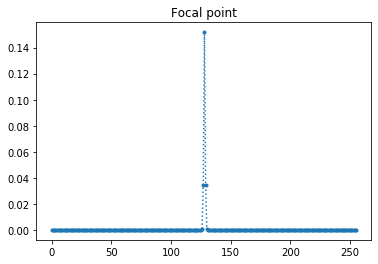

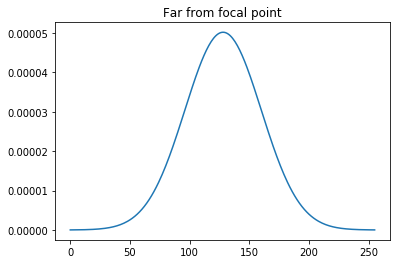

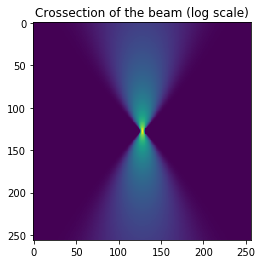

In [18]:
def gaussian_kernel(w0, wz, Nx = 256, Ny = 256, pix = 0.2, wavelength = 0.5):
    
    # Coordinates:
    xx = (numpy.arange(Nx) - Nx//2) * pix
    yy = (numpy.arange(Ny) - Ny//2) * pix

    # Overal intensity:
    beam = (w0 / wz[:, None, None])**2 * numpy.exp(-2*(xx[None, None, :]**2+yy[None, :, None]**2) / wz[:, None, None]**2)
    beam = beam.astype('float32')
    beam /= 2 * numpy.pi

    # Plot:
    pylab.plot(beam[Nx//2,Nx//2, :], ':.')
    pylab.title('Focal point')
    pylab.show()
    
    pylab.plot(beam[0,Nx//2, :])
    pylab.title('Far from focal point')
    pylab.show()

    pylab.imshow(numpy.log(beam[:,Nx//2, :]+1e-5))
    pylab.title('Crossection of the beam (log scale)')
    pylab.show()

    return beam

# Test:
beam = gaussian_kernel(w0, wz, Nx = 256, Ny = 256, pix = 0.2, wavelength = 0.5)

## Generate matrix A: Y = A * X  

We will generate matrix $A$ for vector $X$ that corresponds to a small volume of 30x30x30 elements to make sure $A$ is not too big.

It is assumed here that the cone shape is translation invariant, so we can make $A$ by shifting the cone to every possible focal point.

We will generate $A$ as a tensor, so instead of $X_i$ we could have $X_{ijk}$ (indexed in 3D space). 

In [19]:
# Generate A:
N = 20
A = numpy.zeros((N,N,N,N,N,N), dtype = 'float32')

sz = beam.shape
for ii in range(N):
    for jj in range(N):
        for kk in range(N):
            index = [sz[0]//2-ii, sz[1]//2-jj, sz[2]//2-kk]
            A[ii, jj, kk, :,:,:] = beam[index[0]:index[0]+N, index[1]:index[1]+N, index[2]:index[2]+N]

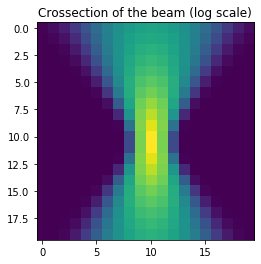

In [28]:
# Test focus beam at point ijk = 15,15,15: 
X = numpy.zeros((N,N,N), dtype = 'float32')
X[10, 10, 10] = 1

Y = numpy.tensordot(A, X, axes = 3)

pylab.imshow(numpy.log(Y[:,10, :]+1e-4))
pylab.title('Crossection of the beam (log scale)')
pylab.show()

## Matrix inverse

We will convert $A$ to a square matrix to use the standard inverse scheme.

In [33]:
N = A.shape[0]

# Moore-Penrose matrix inverse with a regularization parameter:
AI = A.reshape((N*N*N, N*N*N))
AI = numpy.linalg.pinv(AI, rcond = 1e-2)
AI = AI.reshape(N,N,N,N,N,N)

## Test on a simple target image

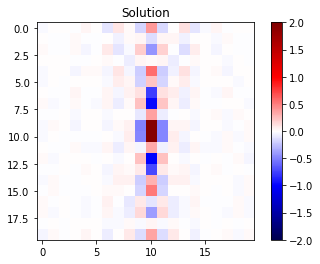

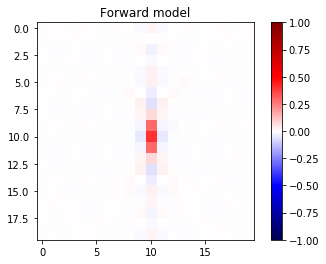

In [67]:
# Make a single point target:
Y0 = numpy.zeros((N,N,N), dtype = 'float32')
Y0[10, 10, 10] = 1

X = numpy.tensordot(AI, Y0, axes = 3)

pylab.imshow(X[:,10, :], vmin = -2, vmax = 2, cmap = 'seismic')
pylab.colorbar()
pylab.title('Solution')
pylab.show()   

# Forward model:
Y = numpy.tensordot(A, X, axes = 3)

pylab.imshow(Y[:,10, :], vmin = -1, vmax = 1, cmap = 'seismic')
pylab.colorbar()
pylab.title('Forward model')
pylab.show()  

## Gradient Descent approach

Text(0.5, 1.0, 'norm')

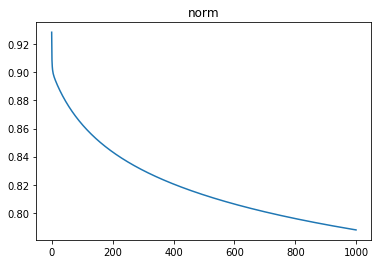

In [106]:
# Iterations:
Niter = 1000

# Norm:
norm = []

# Weight:
one = numpy.zeros((N,N,N), dtype = 'float32')
one[10, 10, 10] = 1
weight = numpy.tensordot(A, one, axes = 3).sum()

# Adjoint:
A_T = numpy.transpose(A, (3,4,5,0,1,2))

# Initial guess 
X0 = numpy.zeros((N,N,N), dtype = 'float32')
X0[10, 10, 10] = 1

for ii in range(Niter):
    
    diff = (Y0 - numpy.tensordot(A, X0, axes = 3))
    X0 = X0 + (2/weight**2)*numpy.tensordot(A_T, diff, axes = 3) 
    
    # Norm:
    norm.append(numpy.linalg.norm(diff))
    
pylab.plot(norm)    
pylab.title('norm')

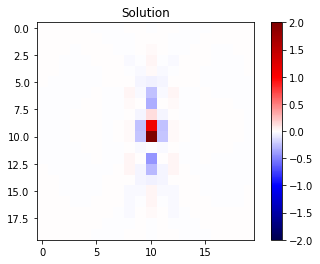

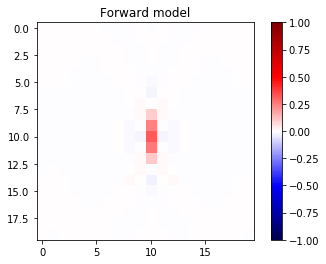

In [107]:
# Display:
pylab.imshow(X0[:,10, :], vmin = -2, vmax = 2, cmap = 'seismic')
pylab.colorbar()
pylab.title('Solution')
pylab.show()   

# Forward model:
Y = numpy.tensordot(A, X0, axes = 3)

pylab.imshow(Y[:,10, :], vmin = -1, vmax = 1, cmap = 'seismic')
pylab.colorbar()
pylab.title('Forward model')
pylab.show()  


### Conclusion:
A naive implementation of the Gradient Descent method is really slow!

We need more than 1000 iterations for this example.

We need pre-conditioning or other tricks to accelerate the convergence. 

## Convolution / deconvolution approach

In this example the beam shape is translation invariant relative to the focal point position (lens effects are neglected).

So we can use convolution instead of matrix multiplication.

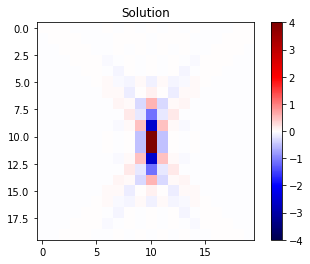

In [104]:
# Compute the solution as a de-convolution of the target with the cone:

# Pad the target image to match in size with the beam image:
Y0p = numpy.pad(Y0, ((0,236),(0,236),(0,236)), mode = 'constant', constant_values =0)

# Target Y and cone in Fourier space:
Y0_ft = numpy.fft.fftn(Y0p)
kernel = numpy.fft.fftn(numpy.fft.fftshift(beam))

# Deconvolve with Tikhonov regularization:
epsilon = 1e-3
X0 = numpy.fft.ifftn(Y0_ft * kernel.conj() / (epsilon + kernel * kernel.conj()))
X0 = numpy.real(X0)

# De-Pad:
X0 = X0[:20,:20,:20]

# Display:
pylab.imshow(X0[:,10, :], vmin = -4, vmax = 4, cmap = 'seismic')
pylab.colorbar()
pylab.title('Solution')
pylab.show()   

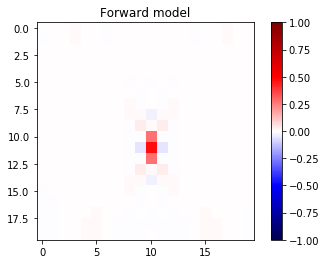

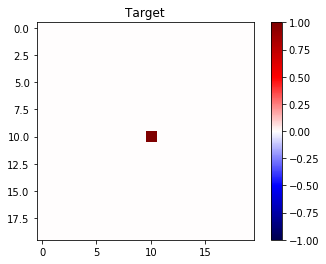

In [105]:
# Forward model (using matrix multiplication):
Y = numpy.tensordot(A, X0, axes = 3)

pylab.imshow(Y[:,10, :], vmin = -1, vmax = 1, cmap = 'seismic')
pylab.colorbar()
pylab.title('Forward model')
pylab.show() 

pylab.imshow(Y0[:,10, :], vmin = -1, vmax = 1, cmap = 'seismic')
pylab.colorbar()
pylab.title('Target')
pylab.show() 

### Conclusion:

Deconvolution is a fast approach and can be applied to large vectors. But it is only applicable if the beam profile doesnt depend on the coordinates of the focal point.